In [97]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
# List of DynamicsNetwork names
import seaborn as sns
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

Mapping the names used in the code to the ones used during the thesis.

In [98]:
# standard MB model keys
mb_methods = ['EnsembleARDModel', 'AutoregressiveDeltaModel', 'ProbsDeltaDynamicsModel', 'AutoregressiveModel', 'DeltaDynamicsModel', 'ProbDynamicsModel', 'SimpleDynamicsModel', 'Simulation']
mb_labels = ['ADM (5)', 'ADM', 'DM (LL)', 'AM', 'DM (MSE)', 'NM (LL)', 'NM (MSE)', 'Simulation']
# Ensemble model keys
mb_methods_ensemble =  ["EnsembleSDModel", "EnsembleARModel", "EnsemblePDDModel", "EnsembleARDModel"]
mb_labels_ensemble = ["NM (5)", "AR (5)", "DM (5)", "ADM (5)"]

# Importance Sampling
is_methods = ['iw_action_step_wis_termination_zero', 
              'iw_action_step_wis_mean', 
              'iw_action_step_wis_zero',
              'iw_action_cobs_wis_zero',
              'iw_action_simple_step_is_zero',
              'iw_action_simple_is_zero',
              'iw_action_phwis_zero']
is_labels = ["TPDWIS",
             "PDWIS (Mean)", 
             "PDWIS (C)", 
             "WIS", 
             "PDIS", 
             "IS", 
             "PHWIS" ]
# fqe
fqe_methods = ["QFitterDD", "QFitterL2"]
fqe_labels = ["FQE (DD)", "FQE (L2)"]

# Doubly robust
dr_methods = ['iw_action_step_wis_termination_zero_dr', 'iw_action_cobs_wis_zero_dr', 'iw_action_simple_step_is_zero_dr','iw_action_simple_is_zero_dr']
dr_labels = ["TPDWIS (DR)", "WIS (DR)", "PDIS (DR)", "IS (DR)"]


Need to define the base paths where we can find these methods, you might have to adjust this.

In [99]:
mb_path = "runs_mb"
dr_path = "runs_dr"
fqe_path = "fqe_all"
is_path = "runs_iw"

In [100]:
# define our rewards
reward_order =["reward_progress", "reward_checkpoint", "reward_lifetime", "reward_min_act"]

In [101]:
all_methods = [ mb_methods, is_methods, fqe_methods, dr_methods, mb_methods_ensemble]
all_paths = [mb_path, is_path, fqe_path, dr_path, mb_path]
label_maps_all = [ mb_labels, is_labels, fqe_labels, dr_labels, mb_labels_ensemble]
family_name = ["MB", "IS", "FQE", "DR", "MB (Ensemble)"]

In [102]:
max_seed = 25
def calculate_stats(metrics):
    stats = {key: {"mean": np.mean(values), "std": np.std(values)} for key, values in metrics.items()}
    stats["regret@1"] = {"mean": np.mean(metrics["regret@1"]), "std": np.std(metrics["regret@1"])}
    return stats

def read_metrics_from_json(base_path, network_name, reward_name="reward_progress"):
    network_path = os.path.join(base_path, network_name, "f110-real-stoch-v2/250/off-policy")
    #network_path = os.path.join("/home/fabian/msc/f110_dope/ws_release/experiments/runs_iw3", network_name, "f110-real-stoch-v2/250/off-policy")
    results = {"spearman_corr": [], "abs": [], "regret@1": []}
    file_not_found_counter = 0 # Counter for files not found
    if os.path.exists(network_path):
        seeds = [d for d in os.listdir(network_path) if os.path.isdir(os.path.join(network_path, d))]
        for seed in seeds:
            if int(seed) > max_seed:
                continue
            json_path = os.path.join(network_path, seed, "results", f"reward_{reward_name}._metrics.json")
            if os.path.isfile(json_path):
                if network_name == "iw":
                    print("??")
                with open(json_path, 'r') as f:
                    print(json_path)
                    data = json.load(f)
                    if 'spearman_corr' in data and 'abs' in data:
                        results['spearman_corr'].append(data['spearman_corr'])
                        results['abs'].append(data['abs'])
            else:
                print(f"File not found: {json_path}")
                file_not_found_counter += 1
            # now read the specific value and compute the regret@1
            # load the ground truth reward
            
            ground_truth_rewards_folder = f"../Groundtruth/gt_{reward_name}.json"
            with open(ground_truth_rewards_folder, "r") as f:
                ground_truth_rewards = json.load(f)
            # get the max from the ground truth rewards
            max_reward = max([ground_truth_rewards[agent]['mean'] for agent in ground_truth_rewards])
            json_path = os.path.join(network_path, seed, "results", f"{reward_name}.json")
            if os.path.isfile(json_path):
                with open(json_path, 'r') as f:
                    print(json_path)
                    data = json.load(f)
                    max_agent = None
                    for agent in data:
                        if max_agent is None or data[agent]['mean'] > data[max_agent]['mean']:
                            max_agent = agent
                    #max_reward_agent = max([data[agent]['mean'] for agent in data])
                    print(max_reward - ground_truth_rewards[max_agent]['mean'])
                    results['regret@1'].append(abs(max_reward - ground_truth_rewards[max_agent]['mean']))
            else:
                print(f"File not found: {json_path}")
                file_not_found_counter += 1
            print(f"Regret@1: {results['regret@1']}")
    else:
        print(f"Path does not exist: {network_path}")
    
    return results, file_not_found_counter

# Extract the data into one common dictionary

In [103]:
curr_rewards = {}
for reward in reward_order:
    curr = {}
    for name, method, label_map, base_path in zip(family_name, all_methods, label_maps_all, all_paths):

        print(name)
        curr[name] = {}
        for network_name, label in zip(method, label_map):
            metrics, files_not_founds = read_metrics_from_json(base_path, network_name, reward_name=reward)
            #print(metrics)

            stats = calculate_stats(metrics)
            curr[name][label] = stats
            #print(f"Results for {network_name}:")
            #print(f"Spearman Correlation: {metrics['spearman_corr']}")
            #print(f"Absolute values: {metrics['abs']}\n")
            #print(f"Regret@1: {metrics['regret@1']}\n")

    curr_rewards[reward] = curr
    print(curr)
    # loop over keys and count items in each key
    for key in curr:
        print(key)
        print(len(curr[key]))
    print(curr.keys())

MB
Path does not exist: runs_mb/EnsembleARDModel/f110-real-stoch-v2/250/off-policy
runs_mb/AutoregressiveDeltaModel/f110-real-stoch-v2/250/off-policy/1/results/reward_reward_progress._metrics.json
runs_mb/AutoregressiveDeltaModel/f110-real-stoch-v2/250/off-policy/1/results/reward_progress.json
7.1560816164709
Regret@1: [7.1560816164709]
runs_mb/AutoregressiveDeltaModel/f110-real-stoch-v2/250/off-policy/0/results/reward_reward_progress._metrics.json
runs_mb/AutoregressiveDeltaModel/f110-real-stoch-v2/250/off-policy/0/results/reward_progress.json
7.1560816164709
Regret@1: [7.1560816164709, 7.1560816164709]
Path does not exist: runs_mb/ProbsDeltaDynamicsModel/f110-real-stoch-v2/250/off-policy
Path does not exist: runs_mb/AutoregressiveModel/f110-real-stoch-v2/250/off-policy
Path does not exist: runs_mb/DeltaDynamicsModel/f110-real-stoch-v2/250/off-policy
Path does not exist: runs_mb/ProbDynamicsModel/f110-real-stoch-v2/250/off-policy
Path does not exist: runs_mb/SimpleDynamicsModel/f110-r

/home/fabian/miniconda3/envs/release/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fabian/miniconda3/envs/release/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fabian/miniconda3/envs/release/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fabian/miniconda3/envs/release/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/fabian/miniconda3/envs/release/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [104]:
print(curr_rewards['reward_checkpoint'])

{'MB': {'ADM (5)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'ADM': {'spearman_corr': {'mean': 0.5624999999999999, 'std': 0.008928571428571397}, 'abs': {'mean': 7.664785784493752, 'std': 0.8653023099750201}, 'regret@1': {'mean': 8.59320490299859, 'std': 5.278959679827732}}, 'DM (LL)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'AM': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'DM (MSE)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'NM (LL)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'NM (MSE)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, '

# Create Plots for different Rewards

In [105]:

def plot_stats_comparison(stats1, stats2, stats3, metric, title="Comparison of Mean and STD of Metric", save_path=None):
    # labels = dynamics_networks  # List of labels assumed to be defined elsewhere
    labels_1 = list(stats1.keys())
    labels_2 = list(stats2.keys())
    labels_3 = list(stats3.keys())
    label_map = labels_1  # Assuming all labels are the same
    # 3 FQE just take FQEDD
    print(stats1)
    print(stats2)
    print(stats3)

    means1 = [stats1[label][metric]['mean'] for label in labels_1]
    errors1 = [stats1[label][metric]['std'] for label in labels_1]
    means2 = [stats2[label][metric]['mean'] for label in labels_2]
    errors2 = [stats2[label][metric]['std'] for label in labels_2]
    means3 = [stats3[label][metric]['mean'] for label in labels_3]
    errors3 = [stats3[label][metric]['std'] for label in labels_3]
    
    # Simplifying label names by removing "Model"
    labels = [label.replace("Model", "") for label in labels_1]
    
    sns.set_theme(style="white")
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25  # Width of the bars
    
    # Plotting
    fqe_mean = [ stats3["FQE (DD)"][metric]['mean']] * len(labels_1)
    fqe_error = [ stats3["FQE (DD)"][metric]['std']] * len(labels_1)
    dr_mean = [ stats1[label][metric]['mean'] for label in labels_1]
    dr_error = [ stats1[label][metric]['std'] for label in labels_1]
    print(labels_1)
    print(labels_2)
    iw_mean = [ stats2[label][metric]['mean'] for label in labels_2]
    iw_error = [ stats2[label][metric]['std'] for label in labels_2]
    print(iw_mean)

    plt.bar(x - 0.25, dr_mean, width, label='Stats1 Mean', yerr=dr_error, capsize=5, color='skyblue')
    plt.bar(x + 0, iw_mean, width, label='Stats2 Mean', yerr=iw_error, capsize=5, color='darkorange') #sns.color_palette()[1])
    plt.bar(x + 0.25,fqe_mean, width, label='Stats3 Mean', yerr=fqe_error, capsize=5, color='green')
    # plt.xlabel('Dynamics Network', fontsize=20)
    if metric == "spearman_corr":
        plt.ylabel("Spearman Correlation", fontsize=20)
    elif metric == "abs":
        plt.ylabel("Mean Absolute Error", fontsize=20)
    elif metric == "regret@1":
        plt.ylabel("Regret@1", fontsize=20)
    plt.title(title, fontsize=22, pad=30)
    plt.xticks(x, label_map, rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(axis='y')
    
    # Adjusting the y-axis limits based on the metric
    if metric == "spearman_corr":
        plt.ylim(-0.5, 1)
    if metric == "abs":
        # make y axis logarithmic
        plt.yscale('log')
        plt.ylim(0, 100)
    elif metric == "regret@1":
        plt.ylim(0, 30)
    # overwrite legend with 1) Naive, 2) Ensemble
    # set legend to the bottom right corner
    # plot the legend outside of the plot

    plt.legend(["DR", "IS", "FQE (DD)"], fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)

    # Adjust layout to make room for the legend
    plt.subplots_adjust(top=0.75)  
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
def plot_grouped_bars(data_dict, title="Grouped Data Comparison", metric="spearman_corr", save=False):
    """
    Plot grouped bar charts with mean and standard deviation, handling varying subkeys.

    Args:
        data_dict (dict): Dictionary with a variable structure of subkeys, like:
                          {
                              'Group1': {'Subkey1': {'spearman_corr': {'mean': val1, 'std': std1}}, ...},
                              'Group2': {'Subkey3': {'spearman_corr': {'mean': val2, 'std': std2}}, ...},
                              ...
                          }
        title (str): Title of the plot.
        metric (str): The metric to plot ('spearman_corr' by default).

    Returns:
        None: Displays the plot.
    """
    # Collecting all unique subkeys across all groups
    #subkeys = set()
    #for group_data in data_dict.values():
    #    subkeys.update(group_data.keys())
    #subkeys = sorted(subkeys)  # Sort to maintain consistent order

    #groups = list(data_dict.keys())
    #n_groups = len(groups)
    #n_subkeys = len(subkeys)

    fig, ax = plt.subplots(figsize=(12, 6))
    #ind = np.arange(n_subkeys)  # the x locations for the groups
    width = 1.0   # the width of the bars

    # Creating bar plots for each group, only where data is available
    prev_group_sizes = 0 # keep track for positioning
    all_subkeys = []
    x_ticks_pos = []
    for i, group in enumerate(data_dict):
        #print(group)
        #print('--------')
        #if group != "DR":
        #    continue
        group_data = data_dict[group]
        group_means = []
        group_errors = []
        group_indices = []

        for subkey in group_data:
            group_means.append(group_data[subkey][metric]['mean'])
            group_errors.append(group_data[subkey][metric]['std'])
                #group_indices.append(j)
        #print(group)
        #print(len(data_dict[group].keys()))
        #print(len(group_means))
        #print(prev_group_sizes * i)
        current_positions = np.arange(len(data_dict[group].keys())) + prev_group_sizes
        ax.bar(np.arange(len(data_dict[group].keys())) + prev_group_sizes, group_means, 0.75, label=group, yerr=group_errors, capsize=5, color=sns.color_palette()[i])
        x_ticks_pos += list(current_positions)
        prev_group_sizes += len(group_means) * width + width
        all_subkeys += list(group_data.keys())
        
    
    #print(title)
    if title=="Min_act Reward":
        ax.set_title("Minimum Action Reward", fontsize = 30)
    else:
        ax.set_title(title, fontsize = 30)
    ax.set_xticks(x_ticks_pos)
    ax.set_xticklabels(all_subkeys)
    if metric == "spearman_corr":
        ax.set_ylabel("Spearman Rank Correlation", fontsize=25)
    elif metric == "abs":
        ax.set_ylabel("Mean Absolute Error", fontsize=25)
    elif metric == "regret@1":
        ax.set_ylabel("Regret@1", fontsize=25)
    #ax.set_ylabel("Spearman Rank Correlation", fontsize=25)
    # set y tick fontsize
    ax.tick_params(axis='y', labelsize=25)
    #ax.legend()
    # set legend to left bottom corner an adjust fontsize
    #ax.legend(fontsize=23, loc='lower left')
    # increase y ticks fontsize
    # set maximum y limit to 1
    if metric == "spearman_corr":
        ax.set_ylim(-0.5, 1)
    
    if metric == "abs":
        # make y axis logarithmic
        plt.yscale('log')
        plt.ylim(0, 100)
    elif metric == "regret@1":
        plt.ylim(0, 30)

    plt.xticks(rotation=45, fontsize=25)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    # strip all whitespaces from metric and title
    metric = metric.replace(" ", "")
    title = title.replace(" ", "")
    if save:
        plt.savefig(f"plots/{metric}_{title}.pdf")
    #plt.savefig(f"plots/0_{metric}_cross_{title}.pdf")
    plt.show()
  

In [106]:
print(reward_order)

['reward_progress', 'reward_checkpoint', 'reward_lifetime', 'reward_min_act']


In [107]:
# select the reward you are interested in plotting
reward = 'reward_progress'
title = "Checkpoint Reward"

dict_keys(['MB', 'IS', 'FQE', 'DR', 'MB (Ensemble)'])


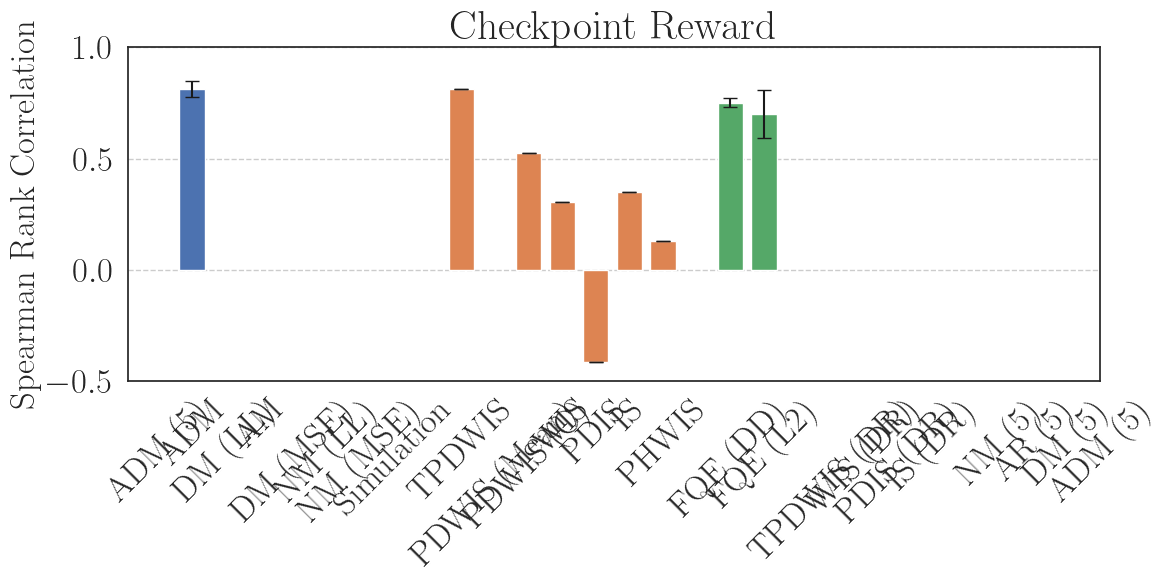

/tmp/ipykernel_83716/3013415859.py:162: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 100)


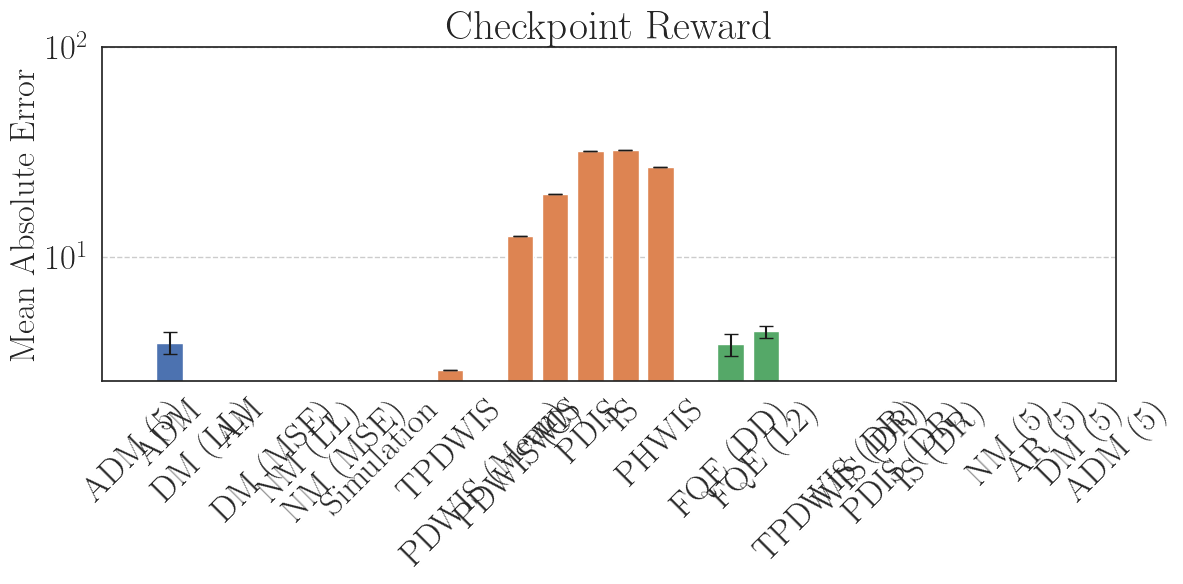

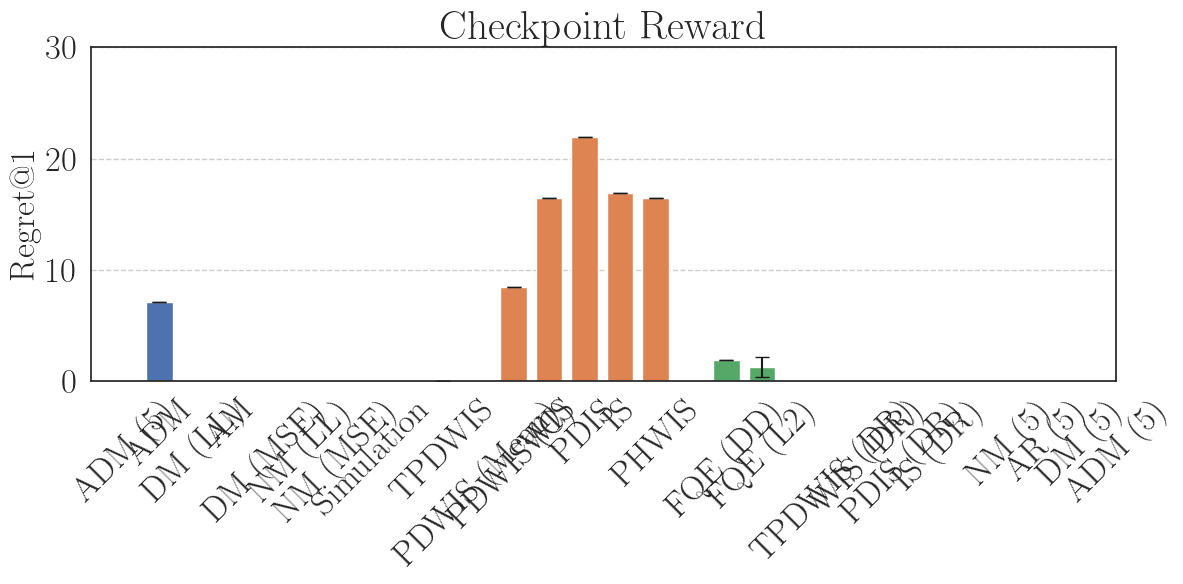

In [108]:
stats = curr_rewards[reward].copy()
print(stats.keys())
# remove some of the keys if you are not interested in them
#stats.pop("MB (Ensemble)")
plot_grouped_bars(stats, title=f"{title}", metric="spearman_corr")
plot_grouped_bars(stats, title=f"{title}", metric="abs")
plot_grouped_bars(stats, title=f"{title}", metric="regret@1")

In [109]:
stats.keys()

dict_keys(['MB', 'IS', 'FQE', 'DR', 'MB (Ensemble)'])

# Specific Plotting DR, IS and FQE (DD) next to each other

In [110]:
# from stats IS select only the relevant keys (TPDWIS, WIS, PDIS, IS)
is_stats = {key: stats["IS"][key] for key in ["TPDWIS", "WIS", "PDIS", "IS"]}


{'TPDWIS (DR)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'WIS (DR)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'PDIS (DR)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'IS (DR)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}}
{'TPDWIS': {'spearman_corr': {'mean': 0.8142857142857142, 'std': 0.0}, 'abs': {'mean': 2.8946127863107756, 'std': 0.0}, 'regret@1': {'mean': 0.0, 'std': 0.0}}, 'WIS': {'spearman_corr': {'mean': 0.3071428571428571, 'std': 0.0}, 'abs': {'mean': 19.918923943594766, 'std': 0.0}, 'regret@1': {'mean': 16.46063084074122, 'std': 0.0}}, 'PDIS': {'spearman_corr': {'mean': -0.4142857142857142, 'std': 0.0}, 'abs': {'mean': 31.90376611183045, 'std': 0.0}, 'regret@1': {'mean': 21.8

PermissionError: [Errno 13] Permission denied: 'plots/00_spearman_corr_comparison_reward_progress_work.pdf'

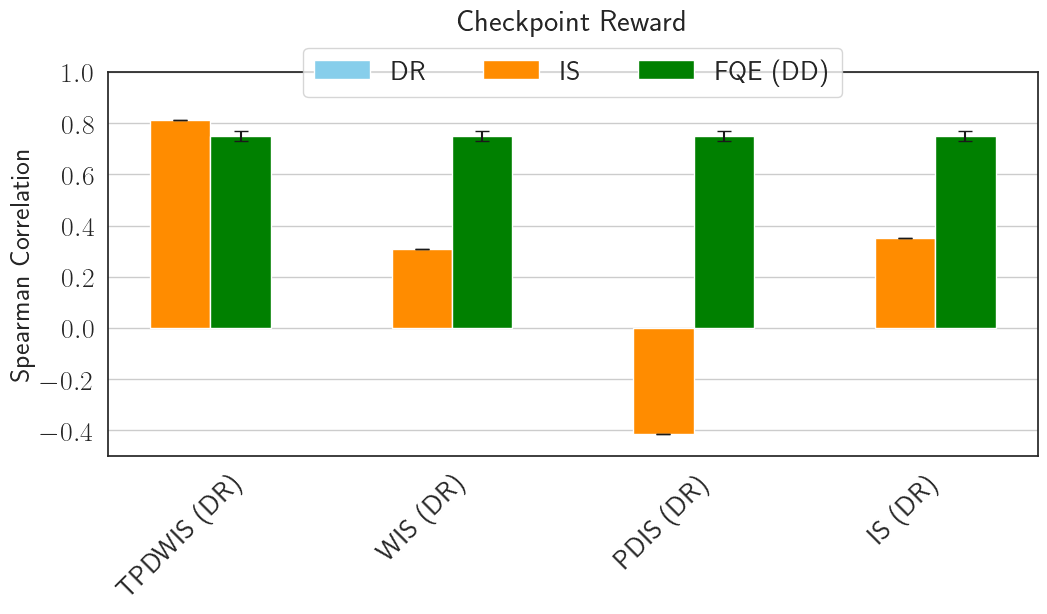

In [111]:
plot_stats_comparison(stats["DR"],is_stats,
                        stats["FQE"],
                        "spearman_corr", title=title, 
                        save_path=f"plots/00_spearman_corr_comparison_{reward}_work.pdf")
plot_stats_comparison(stats["DR"],  is_stats,
                    stats["FQE"],
                    "abs", title=title, 
                    save_path=f"plots/00_abs_{reward}_work.pdf")
plot_stats_comparison(stats["DR"],  is_stats,
                    stats["FQE"],
                    "regret@1", title=title, 
                    save_path=f"plots/00_regret_{reward}_work.pdf")

In [ ]:
print(stats)

{'MB': {'ADM (5)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'ADM': {'spearman_corr': {'mean': 0.8107142857142855, 'std': 0.03571428571428564}, 'abs': {'mean': 3.920104468971827, 'std': 0.4749738864284563}, 'regret@1': {'mean': 7.1560816164709, 'std': 0.0}}, 'DM (LL)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'AM': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'DM (MSE)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'NM (LL)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'NM (MSE)': {'spearman_corr': {'mean': nan, 'std': nan}, 'abs': {'mean': nan, 'std': nan}, 'regret@1': {'mean': nan, 'std': nan}}, 'Simulation': {'s

In [114]:
# select the stats to produce latex table file for
curr = stats["IS"]
print(reward)

reward_progress


In [115]:
with open(f"metrics_{reward}.txt", "w") as f:
    for i, model in enumerate(curr):
        print(f"& {model} & {curr[model]['spearman_corr']['mean']:.2f} $\pm$ {curr[model]['spearman_corr']['std']:.2f}  & {curr[model]['abs']['mean']:.2f} $\pm$ {curr[model]['abs']['std']:.2f}  & {curr[model]['regret@1']['mean']:.2f} $\pm$ {curr[model]['regret@1']['std']:.2f} \\\\ \n")
        f.write(f"& {model} & {curr[model]['spearman_corr']['mean']:.2f} $\pm$ {curr[model]['spearman_corr']['std']:.2f}  & {curr[model]['abs']['mean']:.2f} $\pm$ {curr[model]['abs']['std']:.2f}  & {curr[model]['regret@1']['mean']:.2f} $\pm$ {curr[model]['regret@1']['std']:.2f} \\\\ \n")

& TPDWIS & 0.81 $\pm$ 0.00  & 2.89 $\pm$ 0.00  & 0.00 $\pm$ 0.00 \\ 

& PDWIS (Mean) & nan $\pm$ nan  & nan $\pm$ nan  & nan $\pm$ nan \\ 

& PDWIS (C) & 0.52 $\pm$ 0.00  & 12.62 $\pm$ 0.00  & 8.51 $\pm$ 0.00 \\ 

& WIS & 0.31 $\pm$ 0.00  & 19.92 $\pm$ 0.00  & 16.46 $\pm$ 0.00 \\ 

& PDIS & -0.41 $\pm$ 0.00  & 31.90 $\pm$ 0.00  & 21.89 $\pm$ 0.00 \\ 

& IS & 0.35 $\pm$ 0.00  & 32.45 $\pm$ 0.00  & 16.95 $\pm$ 0.00 \\ 

& PHWIS & 0.13 $\pm$ 0.00  & 27.02 $\pm$ 0.00  & 16.46 $\pm$ 0.00 \\ 

